In [1]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer
import os
import sys
from easydict import EasyDict as edict
import operator
import pickle


In [2]:
#sys.path

In [3]:
#this does't actually need to be protected. More a reminder it's an interim measure
try:
    sys.path.append('../unsupported')
    sys.path.append('./unsupported')
except:
    pass

In [4]:
#
from unsupported_dan.utilities.interpolation import nn_evaluation
from unsupported_dan.interfaces.marker2D import markerLine2D
from unsupported_dan.faults.faults2D import fault2D, fault_collection


../unsupported/unsupported_dan/utilities/__init__.py:9: UserWarning: 

The utilities module is not supported.
Questions should be addressed to sandd@student.unimelb.edu.au 
 
  Questions should be addressed to sandd@student.unimelb.edu.au \n """
../unsupported/unsupported_dan/interfaces/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """
../unsupported/unsupported_dan/faults/__init__.py:9: UserWarning: 

The fault module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """


In [5]:
#from unsupported_dan.cl_args import easy_args


## Functions

In [6]:
def slab_top(trench, normal, gradientFn, ds, maxDepth, mesh):
    """
    Create points representing the top of a slab from trench to maxDepth
    
    Parameter
    ---------
    trench : list or list like 
            Points represnting trench location, 
    normal: list or list like
            vector in the horizontal plane normal to trench
    gradientFn: function
             function that returns the dip or the slab dz/ds 
             where s is the distance along the normal vector
    ds: float
            distance between points, in model coordinates
    
    max depth: float, or list or list like
            Maximum depth of slab
    mesh: uw 2 mesh   
    
    """
    
    #convert everything to numpy arrays
    trench = np.array(trench)
    normal = np.array(normal)/np.linalg.norm(normal)
    maxDepth = np.array(maxDepth)
    
    #test if gradientFn is a function   
    points = []
    points.append(list(trench))
    
    #set starting values
    #normal/= np.linalg.norm(normal)#unitize
    vertical = np.zeros(mesh.dim)
    vertical[-1] = -1.

    P0 = trench.copy()
    F = gradientFn(0.)
    #print(F)
    H = 0.
    V = 0.
    #print(normal, F)
    S = normal.copy()

    S[-1] = F     #assumes the last component is vertical
    S/= np.linalg.norm(S) #unitize

    
    while V < maxDepth:
        
        #Get next set of points
        P1 = P0 + S*ds
        points.append(list(P1))
        P0 = P1
        
        #update, H, V, F, S
        H +=  np.dot(S*ds, normal)
        V +=  abs(((S*ds)[-1]))
        F = gradientFn(H)        
        S = normal.copy()
        S[-1] = F     #assumes the last component is vertical
        S/= np.linalg.norm(S) #unitize

        
        
        
    return(np.array(points))

## Setup out Dirs

In [7]:
############
#Model letter and number
############


#Model letter identifier default
Model = "T"

#Model number identifier default:
ModNum = 1

#Any isolated letter / integer command line args are interpreted as Model/ModelNum

if len(sys.argv) == 1:
    ModNum = ModNum 
elif sys.argv[1] == '-f': #
    ModNum = ModNum 
else:
    for farg in sys.argv[1:]:
        if not '=' in farg: #then Assume it's a not a paramter argument
            try:
                ModNum = int(farg) #try to convert everingthing to a float, else remains string
            except ValueError:
                Model  = farg

In [8]:
###########
#Standard output directory setup
###########

outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" 
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
#checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
xdmfPath = outputPath + 'xdmf/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)
    if not os.path.isdir(xdmfPath):
        os.makedirs(xdmfPath)
        
uw.barrier() #Barrier here so no procs run the check in the next cell too early

## Params

In [9]:
dp = edict({})
#Main physical paramters
dp.depth=300e3                         #Depth
dp.refDensity=3300.                        #reference density
dp.refGravity=9.8                          #surface gravity
dp.viscosityScale=1e20                       #reference upper mantle visc., 
dp.refDiffusivity=1e-6                     #thermal diffusivity
dp.refExpansivity=3e-5                     #surface thermal expansivity
dp.gasConstant=8.314                    #gas constant
dp.specificHeat=1250.                   #Specific heat (Jkg-1K-1)
dp.potentialTemp=1573.                  #mantle potential temp (K)
dp.surfaceTemp=273.                     #surface temp (K)
#Rheology - flow law paramters
dp.cohesionMantle=20e6                   #mantle cohesion in Byerlee law
dp.cohesionInterface=2e6                    #crust cohesion in Byerlee law
dp.frictionMantle=0.2                   #mantle friction coefficient in Byerlee law (tan(phi))
dp.frictionInterface=0.2                   #crust friction coefficient 
dp.diffusionPreExp=5.34e-10             #1./1.87e9, pre-exp factor for diffusion creep
dp.diffusionEnergy=3e5 
dp.diffusionVolume=5e-6

#
dp.interfacePreExp=2e2*5.34e-10            
dp.interfaceEnergy=0.4*3e5
dp.interfaceVolume=5.*5e-6

#power law creep params
dp.powerLawStrain = 1e-15
dp.powerLawExp = 3.5


#Rheology - cutoff values
dp.viscosityMin=1e18
dp.viscosityMax=1e25                #viscosity max in the mantle material
dp.viscosityMinInterface=1e18               #viscosity min in the weak-crust material
dp.viscosityMaxInterface=1e23               #viscosity max in the weak-crust material
dp.yieldStressMax=300*1e6              #

#Intrinsic Lengths
dp.faultThickness = 10*1e3              #interface material (crust) an top of slabs
dp.leftSide=-1.*(150e3)               #
dp.rightSide=(150e3)
dp.theta=45.                             #Angle of slab
dp.radiusOfCurv = 250e3                          #radius of curvature
dp.slabAge=70e6                     #age of subduction plate at trench
dp.opAge=35e6                       #age of op
dp.subZoneLoc=dp.leftSide                    #X position of subduction zone...km
dp.subVelocity = 4*(1/100.)*(1./(3600*24*365)) #m/s

#for a stress-equivalent iso-visc model
dp.brittleDuctile = 50e3
dp.deepInterfaceFcFac = 0.
dp.deepInterfaceCFac = 1. 



#derived params
dp.deltaTemp = dp.potentialTemp-dp.surfaceTemp
dp.tempGradMantle = (dp.refExpansivity*dp.refGravity*(dp.potentialTemp))/dp.specificHeat
dp.tempGradSlab = (dp.refExpansivity*dp.refGravity*(dp.surfaceTemp + 400.))/dp.specificHeat





#Modelling and Physics switches

md = edict({})
md.refineMeshStatic=True
md.stickyAir=False
md.aspectRatio=1.
md.res=96
md.ppc=20                                #particles per cell
#md.elementType="Q1/dQ0"
md.elementType="Q2/DPC1"
md.courantFac=0.5                         #extra limitation on timestepping
md.nltol = 0.001
md.maxSteps = 2000
md.druckerAlpha = 0.
md.druckerAlphaFault = 0.
md.penaltyMethod = True
md.spuniform = False
md.dissipativeHeating = True
md.powerLaw = False
md.interfaceDiffusivityFac = 1.
md.interfaceViscType = 2  #1, 2,  



In [10]:
uw.barrier()

In [14]:
##Parse any command-line args

from unsupported_dan.easymodels import easy_args
sysArgs = sys.argv

#We want to run this on both the paramter dict, and the model dict
easy_args(sysArgs, dp)
easy_args(sysArgs, md)

../unsupported/unsupported_dan/easymodels/__init__.py:9: UserWarning: 

The easymodels module is not supported.
Questions should be addressed to sandd@student.unimelb.edu.au 
 
  Questions should be addressed to sandd@student.unimelb.edu.au \n """


In [15]:
sf = edict({})

sf.lengthScale=300e3
sf.viscosityScale = dp.viscosityScale
sf.stress = (dp.refDiffusivity*sf.viscosityScale)/sf.lengthScale**2
sf.lithGrad = dp.refDensity*dp.refGravity*(sf.lengthScale)**3/(sf.viscosityScale*dp.refDiffusivity) 
sf.lithGrad = (sf.viscosityScale*dp.refDiffusivity) /(dp.refDensity*dp.refGravity*(sf.lengthScale)**3)
sf.velocity = dp.refDiffusivity/sf.lengthScale
sf.strainRate = dp.refDiffusivity/(sf.lengthScale**2)
sf.time = 1./sf.strainRate
sf.actVolume = (dp.gasConstant*dp.deltaTemp)/(dp.refDensity*dp.refGravity*sf.lengthScale)
sf.actEnergy = (dp.gasConstant*dp.deltaTemp)
sf.diffusionPreExp = 1./sf.viscosityScale
sf.deltaTemp  = dp.deltaTemp
sf.pressureDepthGrad = (dp.refDensity*dp.refGravity*sf.lengthScale**3)/(dp.viscosityScale*dp.refDiffusivity)


#sf.dislocationPreExp = ((dp.refViscosity**(-1.*dp.dislocationExponent))*(dp.refDiffusivity**(1. - dp.dislocationExponent))*(sf.lengthScale**(-2.+ (2.*dp.dislocationExponent)))),
#sf.peierlsPreExp = 1./2.6845783276046923e+40 #same form as Ads, but ndp.np =20. (hardcoded because numbers are too big)





In [16]:
#dimesionless params
ndp  = edict({})

ndp.rayleigh = (dp.refExpansivity*dp.refDensity*dp.refGravity*dp.deltaTemp*sf.lengthScale**3)/(dp.viscosityScale*dp.refDiffusivity)
ndp.dissipation = (dp.refExpansivity*sf.lengthScale*dp.refGravity)/dp.specificHeat


#Take care with these definitions, 
ndp.surfaceTemp = dp.surfaceTemp/sf.deltaTemp  #Ts
ndp.potentialTemp = dp.potentialTemp/sf.deltaTemp - ndp.surfaceTemp #Tp' = Tp - TS

ndp.tempGradMantle = dp.tempGradMantle/(sf.deltaTemp/sf.lengthScale)
ndp.tempGradSlab = dp.tempGradSlab/(sf.deltaTemp/sf.lengthScale)

#lengths / distances
ndp.depth = dp.depth/sf.lengthScale
ndp.leftSide = dp.leftSide/sf.lengthScale             #
ndp.rightSide = dp.rightSide/sf.lengthScale
ndp.faultThickness = dp.faultThickness/sf.lengthScale



#times - for convenience the dimensional values are in years, conversion to seconds happens here
ndp.slabAge =  dp.slabAge*(3600*24*365)/sf.time
ndp.opAge = dp.opAge*(3600*24*365)/sf.time


#Rheology - flow law paramters
ndp.cohesionMantle=dp.cohesionMantle/sf.stress                  #mantle cohesion in Byerlee law
ndp.cohesionInterface=dp.cohesionInterface/sf.stress                  #crust cohesion in Byerlee law
ndp.frictionMantle=dp.frictionMantle/sf.lithGrad                  #mantle friction coefficient in Byerlee law (tan(phi))
ndp.frictionInterface=dp.frictionInterface/sf.lithGrad                  #crust friction coefficient 
ndp.diffusionPreExp=dp.diffusionPreExp/sf.diffusionPreExp                #pre-exp factor for diffusion creep
ndp.diffusionEnergy=dp.diffusionEnergy/sf.actEnergy
ndp.diffusionVolume=dp.diffusionVolume/sf.actVolume
#
ndp.interfacePreExp = dp.interfacePreExp/sf.diffusionPreExp           
ndp.interfaceEnergy = dp.interfaceEnergy/sf.actEnergy
ndp.interfaceVolume = dp.interfaceVolume/sf.actVolume

#
ndp.powerLawStrain = dp.powerLawStrain/sf.strainRate
ndp.powerLawExp = dp.powerLawExp

ndp.yieldStressMax=dp.yieldStressMax/sf.stress 


#Rheology - cutoff values
ndp.viscosityMin= dp.viscosityMin /sf.viscosityScale
ndp.viscosityMax=dp.viscosityMax/sf.viscosityScale
ndp.viscosityMinInterface= dp.viscosityMinInterface /sf.viscosityScale
ndp.viscosityMaxInterface = dp.viscosityMaxInterface/sf.viscosityScale




#Slab and plate init. parameters
ndp.subZoneLoc = dp.subZoneLoc/sf.lengthScale
ndp.radiusOfCurv = dp.radiusOfCurv/sf.lengthScale
ndp.theta=dp.theta #Angle of slab
ndp.subVelocity = dp.subVelocity/sf.velocity

#for a stress-equivalent iso-visc model
ndp.brittleDuctile = dp.brittleDuctile/sf.lengthScale
ndp.deepInterfaceFcFac = dp.deepInterfaceFcFac
ndp.deepInterfaceCFac  = dp.deepInterfaceCFac



In [17]:
#ndp.powerLawStrain, ndp.powerLawExp
#dp.viscosityScale, sf.lengthScale

## Make mesh / FeVariables

In [18]:
#1. - ndp.depth

In [19]:
#Domain and Mesh paramters
yres = int(md.res)
xres = int(md.res*md.aspectRatio) 



mesh = uw.mesh.FeMesh_Cartesian( elementType = (md.elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = (ndp.leftSide, 1. - ndp.depth), 
                                 maxCoord    = (ndp.rightSide, 1.)) 

velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
initialtemperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

stressField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=3 )


temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 ) #create this only if Adv-diff
diffusivityFn = fn.misc.constant(1.)
    


In [20]:
velocityField.data[:] = 0.
pressureField.data[:] = 0.
temperatureField.data[:] = 0.
initialtemperatureField.data[:] = 0.

In [21]:
#Uw geometry shortcuts

coordinate = fn.input()
depthFn = mesh.maxCoord[1] - coordinate[1] #a function providing the depth


xFn = coordinate[0]  #a function providing the x-coordinate
yFn = coordinate[1]


## Swarm

In [22]:
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
materialVariable      = swarm.add_variable( dataType="int", count=1 )

layout = uw.swarm.layouts.PerCellRandomLayout(swarm=swarm, particlesPerCell=int(md.ppc))
swarm.populate_using_layout( layout=layout ) # Now use it to populate.


In [23]:
proximityVariable      = swarm.add_variable( dataType="int", count=1 )
signedDistanceVariable = swarm.add_variable( dataType="double", count=1 )
directorVector   = swarm.add_variable( dataType="double", count=2)

#To be general we'll have swarm variables  for friction coefficient and cohesion
fcVariable = swarm.add_variable( dataType="double", count=1 )
fMuVariable= swarm.add_variable( dataType="double", count=1 )


directorVector.data[:,:] = 0.0
proximityVariable.data[:] = 0
signedDistanceVariable.data[:] = 0.0

## Fault / interface

In [24]:
#Create some slab gradient functions to use with slab_top()


def linearGradientFn(S):
    return np.tan(np.deg2rad(-1.*ndp.theta))


def circGradientFn(S):
    if S == 0.:
        return 0.
    elif S < ndp.radiusOfCurv:
        return -S/np.sqrt((ndp.radiusOfCurv**2 - S**2))
    else:
        return -1e5
    
    
def polyGradientFn(S):
    if S == 0.:
        return 0.
    else:
        return -1*(S/ndp.radiusOfCurv)**2

In [25]:
gradFn = linearGradientFn

In [26]:
#data2 = slab_top([ndp.subZoneLoc, 1.0], normal, polyGradientFn, ds, ndp.maxDepth, mesh)
1. - ndp.depth

0.0

In [27]:
ds = 2e3/sf.lengthScale
normal = [1.,0.]

faultData = slab_top([ndp.subZoneLoc, 1.0], normal, gradFn, ds, ndp.depth, mesh)
fault = markerLine2D(mesh, velocityField, faultData[:,0] , faultData[:,1] , ndp.faultThickness, 1.)


In [28]:
#This block sets a number of variables that we'll used to define / control the fault geom

#proximityVariable.data[:] = 0

sd, dnz = fault.compute_signed_distance(swarm.particleCoordinates.data)
f, nz = fault.compute_marker_proximity(swarm.particleCoordinates.data)    
proximityVariable.data[nz] = f[nz]

dv, nzv = fault.compute_normals(swarm.particleCoordinates.data)
directorVector.data[nzv] = dv[nzv]


##Now use the signed distance var to set everything above the fault to zero

sd, dnz = fault.compute_signed_distance(swarm.particleCoordinates.data, distance=3*ndp.depth)

proximityVariable.data[dnz[(sd < 0)[:,0]]] = 0.
directorVector.data[dnz[(sd < 0)[:,0]]] = 0.



signedDistanceVariable.data[dnz] = sd[dnz]

#
upperLowerVar = uw.swarm.SwarmVariable(swarm, 'double', 1)
upperLowerVar.data[...] = 1.
upperLowerVar.data[dnz[(sd > 0)[:,0]]  ] = 0.  



1
1


In [31]:
#fig= glucifer.Figure(quality=3, boundingBox=( (0.2,0.1), (0.4,0.3) ))
#fig= glucifer.Figure(quality=3)
#fig.append( glucifer.objects.Points(swarm, proximityVariable, pointSize=3.5, colourBar=False))
#fig.append( glucifer.objects.Points(fault.swarm, pointSize=5, colourBar=False))
#fig.append( glucifer.objects.Mesh(mesh, opacity=0.4))

#fig.show()
#fig.save_image('proximity.png')

## Set up some distance variables

In [32]:
angleCorrect = 1./(np.sin(np.deg2rad(90. - np.abs(np.rad2deg(np.arctan(gradFn(0.)))))))

conditions = [ (upperLowerVar > 0, depthFn),
                   (                      True , angleCorrect*signedDistanceVariable   ) ]

distFn = fn.branching.conditional( conditions )
    


In [33]:
#angleCorrect 

## Temp. Field

In [34]:
proxyTempVariable = uw.swarm.SwarmVariable(swarm, 'double', 1)

conditions = [ (upperLowerVar > 0, fn.math.erf((distFn)/(2.*np.sqrt(1.*ndp.opAge)))),
                   (                      True , fn.math.erf((distFn)/(2.*np.sqrt(1.*ndp.slabAge)))   ) ]

tempFn = fn.branching.conditional( conditions )

proxyTempVariable.data[:] = tempFn.evaluate(swarm)

In [35]:
#projectorTemp = uw.utils.MeshVariable_Projection( temperatureField, proxyTempVariable, type=0 )
#projectorTemp.solve()


In [36]:
ix0, weights0, d0 = nn_evaluation(swarm.particleCoordinates.data, 
                                  mesh.data , n=100, weighted=False)


temperatureField.data[:,0] =  np.average(tempFn.evaluate(swarm)[:,0][ix0], weights=weights0, axis=len((weights0.shape)) - 1)

initialtemperatureField.data[:,0] =  np.average(tempFn.evaluate(swarm)[:,0][ix0], weights=weights0, axis=len((weights0.shape)) - 1)

In [37]:
#tempFn.evaluate(swarm)[:,0][ix0]


## Boundary Conditions

In [38]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls =mesh.specialSets["MinJ_VertexSet"]
lWalls = mesh.specialSets["MinI_VertexSet"]
rWalls = mesh.specialSets["MaxI_VertexSet"]
      
        


In [39]:
#make sure tempBcs are set exactly on mesh BCs

fTleft = fn.math.erf((depthFn)/(2.*np.sqrt(1.*ndp.slabAge)))
temperatureField.data[lWalls.data] = fTleft.evaluate(lWalls)

fTright = fn.math.erf((depthFn)/(2.*np.sqrt(1.*ndp.opAge)))
temperatureField.data[rWalls.data] = fTright.evaluate(rWalls)

temperatureField.data[tWalls.data] = 0.
temperatureField.data[bWalls.data] = ndp.potentialTemp


del fTleft 
del fTright

In [40]:
#Now we need to set the velocity in the Slab 

In [41]:
conditions =  [ (operator.and_( upperLowerVar < 0.5, proximityVariable < 0.5), 1.),
                   (                      True , 0.)    ]



velBcSwarmFn = fn.branching.conditional( conditions )

In [42]:
bcMeshVar = uw.mesh.MeshVariable(mesh, 1, dataType='double')

projectorMisc = uw.utils.MeshVariable_Projection( bcMeshVar, velBcSwarmFn, type=0 )
projectorMisc.solve()

def circleFn(centre, radius):
    _circFn = (((coordinate[0] - centre[0])**2) + ((coordinate[1] - centre[1])**2)) < radius**2
    return _circFn

circ1 = circleFn((-0.25, 0.8), 0.05)
nodes = circ1.evaluate(mesh).nonzero()[0]

In [43]:
nodes = np.where(bcMeshVar.evaluate(mesh) > 0.5 )[0]
#nodes = np.where(mesh.data[:,1] < (1. - (mesh.data[:,0] + 0.5)))[0]

velocityField.data[:] = 0.
rotMatrix = np.array([[np.cos(-1.*np.deg2rad(ndp.theta)), -np.sin(-1.*np.deg2rad(ndp.theta)) ], 
                         [np.sin(-1.*np.deg2rad(ndp.theta)),  np.cos(-1.*np.deg2rad(ndp.theta))]])
velHat = np.dot(rotMatrix, [1.0,0.])
velocityField.data[nodes]= velHat*ndp.subVelocity


drivenVel = mesh.specialSets["Empty"]
drivenVel.add(nodes)

drivenVel = drivenVel #- lWalls - bWalls




In [44]:
#nodes

In [45]:
print("!!!!!!!!!!!!!!!!!!!!!!!!!!Number of nodes is:", len(drivenVel.data))

('!!!!!!!!!!!!!!!!!!!!!!!!!!Number of nodes is:', 16912)


In [46]:
#All the bCs

stressField.data[...] = (0.0,0.0,0.0)


#Velocity
velNbc = uw.conditions.NeumannCondition( flux=stressField, 
                                      variable=velocityField,
                                      nodeIndexSet=(iWalls + bWalls) )

velDbc = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( tWalls + drivenVel, tWalls + drivenVel) )



#Temp

dT_dy = [0.,0.]
tempNbc = uw.conditions.NeumannCondition( flux=dT_dy, variable=temperatureField,
                                              nodeIndexSet = (bWalls) )
    
    
tempDbc = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               indexSetsPerDof =  tWalls + iWalls )

## Rheology

In [47]:
symStrainrate = fn.tensor.symmetric( 
                            velocityField.fn_gradient )

#Set up any functions required by the rheology
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))



def safe_visc(func, viscmin=ndp.viscosityMin, viscmax=ndp.viscosityMax):
    return fn.misc.max(viscmin, fn.misc.min(viscmax, func))



#Add some portion of dynamic pressure to the depth-dependent Yield function
dynamicPressureProxyDepthFn = pressureField/sf.pressureDepthGrad

druckerDepthFn = fn.misc.max(0.0, depthFn + md.druckerAlpha*(dynamicPressureProxyDepthFn))
druckerFaultDepthFn = fn.misc.max(0.0, depthFn + md.druckerAlphaFault*(dynamicPressureProxyDepthFn))

In [48]:
##Mantle rheology
diffusion = (1./ndp.diffusionPreExp)*\
            fn.math.exp( ((ndp.diffusionEnergy + (depthFn*ndp.diffusionVolume))/((temperatureField+  ndp.surfaceTemp))))
    

    
    
viscosity0 = safe_visc(diffusion, viscmax=1e5)

if md.powerLaw:
    powerLawSRFn= ((strainRate_2ndInvariant+ 1e-15)/ndp.powerLawStrain)**((1.-ndp.powerLawExp)/ndp.powerLawExp)
    viscPower = viscosity0*powerLawSRFn
    effviscosity = viscPower*viscosity0/(viscPower + viscosity0)
    viscosity = safe_visc(effviscosity, viscmax=1e5)

else:
    viscosity = viscosity0

mantleViscosityFn = safe_visc(viscosity,  viscmax=ndp.viscosityMax)

    

 

In [49]:
#md.interfaceViscType = 1
ndp.deepInterfaceFcFac = 1.
md.interfaceViscType 

2

In [50]:
#Interface rheology

if md.interfaceViscType == 1: # a visco-plastic implementation
    
    diffusionInterface = (1./ndp.interfacePreExp)*\
            fn.math.exp( ((ndp.interfaceEnergy + (depthFn*ndp.interfaceVolume))/((temperatureField + ndp.surfaceTemp))))
    

    interfaceDiffusion = safe_visc(diffusionInterface, viscmax=ndp.viscosityMaxInterface)
    #Setting upper / lower visc limits resuls in an for isoviscous crust, enforced here   
    if ndp.viscosityMaxInterface == ndp.viscosityMinInterface:
        interfaceDiffusion = ndp.viscosityMaxInterface
        
    ##Interface plasticity
    ndp.effStrainRate = ndp.subVelocity/ndp.faultThickness
    stressBdt= ndp.cohesionInterface + (ndp.brittleDuctile*ndp.frictionInterface)
    interfaceysUpper =  ndp.cohesionInterface + (druckerFaultDepthFn*ndp.frictionInterface)
    interfaceysLower = ndp.deepInterfaceCFac*(stressBdt) + ndp.deepInterfaceFcFac*((depthFn - ndp.brittleDuctile) *ndp.frictionInterface)

    
    
    interfaceYielding= fn.branching.conditional( ((depthFn < ndp.brittleDuctile, interfaceysUpper/(2.*(strainRate_2ndInvariant) + 1e-15) ), 
                                           (True,                      interfaceysLower/(2.*(strainRate_2ndInvariant) + 1e-15))  ))
    
    #interfaceysf = fn.misc.min(interfaceys, ndp.yieldStressMax)
    #interfaceYielding = interfaceysf/(2.*(strainRate_2ndInvariant) + 1e-15)
    
    #combine
    interfaceViscosityFn = safe_visc(fn.misc.min(interfaceDiffusion, interfaceYielding), viscmin=ndp.viscosityMinInterface, viscmax=ndp.viscosityMax)

        
if md.interfaceViscType == 2: # an equivalent visc implementation
    ndp.effStrainRate = ndp.subVelocity/ndp.faultThickness
    stressBdt= ndp.cohesionInterface + (ndp.brittleDuctile*ndp.frictionInterface)
    effStressUpper =  ndp.cohesionInterface + (depthFn*ndp.frictionInterface)
    effViscUpper = effStressUpper/(2.*ndp.effStrainRate)   
    effStressLower = ndp.deepInterfaceCFac*(stressBdt) + ndp.deepInterfaceFcFac*((depthFn - ndp.brittleDuctile) *ndp.frictionInterface)
    effViscLower  = effStressLower/(2.*ndp.effStrainRate) 
    
    interfacVisc0= fn.branching.conditional( ((depthFn < ndp.brittleDuctile, effViscUpper  ), 
                                           (True,                      effViscLower)  ))
    
    
    #combine
    interfaceViscosityFn = safe_visc(interfacVisc0, viscmin=ndp.viscosityMinInterface, viscmax=ndp.viscosityMax)

    


In [51]:
#ndp.viscosityMax

In [52]:

#interfaceViscosityFn = safe_visc(fn.misc.min(interfaceDiffusion, interfaceYielding), viscmin=ndp.viscosityMinInterface, viscmax=ndp.viscosityMax)



In [53]:
viscosityMapFn = fn.branching.map( fn_key = proximityVariable,
                         mapping = {0:mantleViscosityFn,
                                    1:interfaceViscosityFn} )

viscosityTI2_fn = viscosityMapFn - 10.

# This one maps to my fault-proximity variable (which also picks only materialV)
viscosity2Map    = { 0: 0.0, 
                     1: viscosityTI2_fn                  
                   }

secondViscosityFn  = fn.branching.map( fn_key = proximityVariable, 
                                       mapping = viscosity2Map )


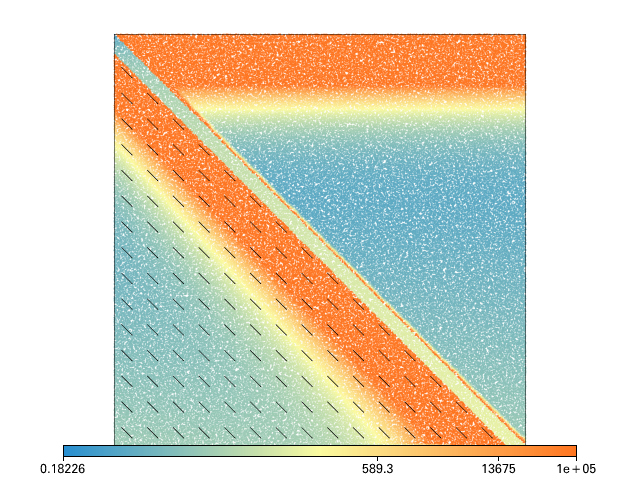

In [54]:
fig= glucifer.Figure(quality=3)

fig.append( glucifer.objects.Points(swarm,viscosityMapFn, logScale=True, pointSize=2))
#fig.append( glucifer.objects.Points(swarm, temperatureField, pointSize=0.8))
#fig.append( glucifer.objects.Contours(mesh,temperatureField, colours='black', interval=0.25,))
#fig.append( glucifer.objects.Contours(mesh,initialtemperatureField, colours='blue', interval=0.25))


#fig.append( glucifer.objects.Points(swarm, directorVector[0], pointSize=2))

#fig.append( glucifer.objects.Points(fault.swarm, pointSize=3, colourBar=False))
#fig.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField,velocityField), pointSize=3, discrete=True))
#fig.append( glucifer.objects.Surface(mesh, effViscLower, pointSize=3, discrete=True))

fig.append( glucifer.objects.VectorArrows(mesh, velocityField*0.0001  ))
#fig.append( glucifer.objects.Mesh(mesh, opacity = 0.3  ))

fig.show()
#fig.save_image('test.png')

In [275]:
uw.barrier()

## Stokes

In [276]:
stokesPIC = uw.systems.Stokes( velocityField  = velocityField, 
                                   pressureField  = pressureField,
                                   conditions     = [velDbc,velNbc],
                                   fn_viscosity   = viscosityMapFn, 
                                   fn_bodyforce   = (0., 0.) )

stokesPIC = uw.systems.Stokes( velocityField  = velocityField, 
                                   pressureField  = pressureField,
                                   conditions     = [velDbc,velNbc],
                                   fn_viscosity   = viscosityMapFn, 
                                   fn_bodyforce   = (0., 0.) ,
                                    _fn_viscosity2  = secondViscosityFn,
                                    _fn_director    = directorVector)

In [277]:
solver = uw.systems.Solver(stokesPIC)


    
    
    



In [278]:
#solver.set_penalty(1.0e7)
#solver.set_inner_method("mumps")
#solver.options.main.Q22_pc_type='uw'
#solver.options.scr.ksp_rtol = 1.0e-4

In [279]:
#md.penaltyMethod = False
#solver.options.main.list()
#md.penaltyMethod


In [280]:

if md.penaltyMethod:
    solver.set_inner_method("mumps")
    solver.options.scr.ksp_type="cg"
    solver.set_penalty(1.0e7)
    solver.options.scr.ksp_rtol = 1.0e-4

else:
    solver.options.main.Q22_pc_type='gkgdiag'
    solver.options.scr.ksp_rtol=5e-5
    solver.set_inner_method('mg')
    solver.options.mg.levels = 4

In [281]:
#solver.options.main.Q22_pc_type?

In [282]:
print("First solve")

First solve


In [283]:
solver.solve(nonLinearIterate=True, nonLinearTolerance=md.nltol)


In [284]:
#md.penaltyMethod

In [285]:
uw.barrier()

In [286]:
print("solve done")

solve done


## Dissipative heatingFn

In [59]:
#dissipative heating in terms of the sqrt. strain rate second invariant is:

if md.dissipativeHeating:
    dissHeatfn = (ndp.dissipation/ndp.rayleigh)*8.*viscosityMapFn*fn.math.sqrt(strainRate_2ndInvariant)
else:
    dissHeatfn = fn.misc.constant(0.)
    
#also a swarmVar for the total change in temp in the Eulerian (we don't advect the swarm in this model) reference    
accumulatedTemp = uw.swarm.SwarmVariable(swarm, 'double', 1)
accumulatedTemp.data[:] = 0.

## fault diffusivity

In [60]:
diffusivityFn = fn.branching.map( fn_key = proximityVariable,
                         mapping = {0:1.,
                                    1:md.interfaceDiffusivityFac} )

In [61]:
#md.interfaceDiffusivityFac

## Advection - Diffusion

In [58]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = dissHeatfn,
                                         fn_diffusivity = diffusivityFn , 
                                         conditions     = [tempNbc, tempDbc] )


In [59]:
dt = advDiff.get_max_dt()*md.courantFac #additional md.courantFac helps stabilise advDiff
advDiff.integrate(dt)
print(dt)

6.43319861078e-06



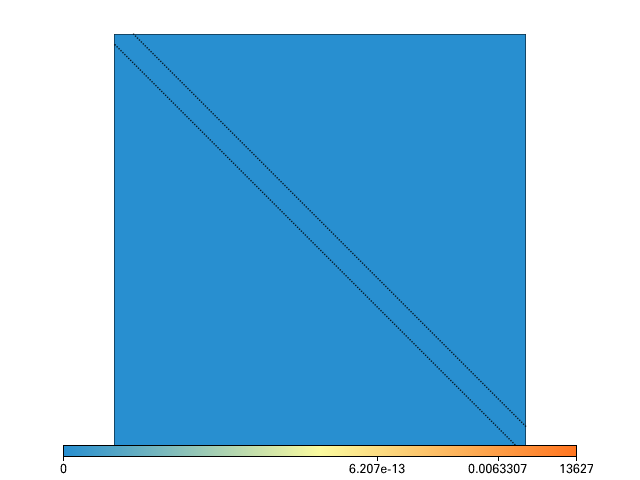

In [415]:
fig= glucifer.Figure(quality=3)

#fig.append( glucifer.objects.Points(swarm, viscosityMapFn, pointSize=2, logScale=True ))

#fig.append( glucifer.objects.Points(swarm, proximityVariable, pointSize=0.7))

#fig.append( glucifer.objects.Points(fault.swarm, pointSize=3, colourBar=False))
#fig.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField,velocityField)))
fig.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True))

fig.append( glucifer.objects.Points(markerEvalFault , pointSize=2, colourBar=False))
fig.append( glucifer.objects.Points(markerEvalMantle , pointSize=2, colourBar=False))


#fig.append( glucifer.objects.VectorArrows(mesh, velocityField*0.0001  ))
#fig.append( glucifer.objects.Mesh(mesh, opacity = 0.3  ))
#fig.append( glucifer.objects.Contours( mesh, depthFn, labelFormat='', unitScaling=1.0, interval=0.2, colours='black'))

fig.show()
#fig.save_database('test.gldb')

## Equilibrium

In [61]:
prevTempField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1)


prevTempField.data[:] = 0.


In [62]:
def volumeint(Fn = 1., rFn=1.):
    return uw.utils.Integral( Fn*rFn,  mesh )

In [400]:
def run_to_equil(maxIts= 4, res = 0.001 ):
    
    resVals = []
    count = 0
    times = []
    elapsedTime = 0
    
    for i in range(maxIts):
        
        #Set previous temp field
        prevTempField.data[:] = temperatureField.data[:] 
    
        #Solve stokes  
        
        solver.solve(nonLinearIterate=True, nonLinearTolerance=md.nltol)

        
        #Solve advection-Diffusion
        
        dt = advDiff.get_max_dt()*md.courantFac #additional md.courantFac helps stabilise advDiff
        advDiff.integrate(dt)
    
    
        #L2 norm of delta Temp

        delT = temperatureField - prevTempField
        t2 = fn.math.dot(delT,  delT)
        _Tr = volumeint(t2)
        delTL2 = np.sqrt(_Tr.evaluate()[0])
        
        resVals.append(delTL2)
        count += 1
        elapsedTime += dt
        times.append(elapsedTime)
        
        #track the temp change due to dissipative heating
        accumulatedTemp.data[:] += dissHeatfn.evaluate(swarm)*dt

        
        
        if delTL2 < res:
            #print('break', str(delTL2), str(res))
    
            break
            
    print('step :', str(count ))
    print('residual val :', str(delTL2))
        
    return resVals , times


In [401]:
tempResiduals, times = run_to_equil(10, res = 0.00001 )

('step :', '100')
('residual val :', '0.000352275171185')


In [414]:
#(times[-1]*sf.time)/(3600*24*365)

In [55]:
#%pylab inline
#fig, ax = plt.subplots()
#ax.plot(tempResiduals)
#ax.hlines(tempResiduals[-1], 0, len(tempResiduals))

## Save some Xdmfs

In [416]:
# Any extra mesh vars. we want to define (mostly to facilite saving as xdmf)
strainRateField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
viscosityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [417]:
def save_xdmfs():
    
    #define any NN interps we'll need
    ix1, weights1, d1 = nn_evaluation(swarm.particleCoordinates.data, mesh.data, n=5, weighted=True)
    
    
    #rebuild any mesh vars that are not self-updating
    viscosityField.data[:,0] =  np.average(viscosityMapFn.evaluate(swarm)[:,0][ix1], weights=weights1, axis=len((weights1.shape)) - 1)
    strainRateField.data[:] = strainRate_2ndInvariant.evaluate(mesh)
     
    
    fullpath = os.path.join(outputPath + "xdmf/")
    #if not os.path.exists(fullpath+"mesh.h5"):
    #    _mH = mesh.save(fullpath+"mesh.h5")
    
    try:
        _mH
    except:
        _mH = mesh.save(fullpath+"mesh.h5")
    
    
    #Part 1
    mh = _mH
    vH = velocityField.save(fullpath + "velocity_" + str(step) +".h5")
    tH = temperatureField.save(fullpath + "temp_" + str(step) + ".h5")
    srH = strainRateField.save(fullpath + "strainrate_" + str(step) +".h5")
    viscH = viscosityField.save(fullpath + "visc_" + str(step) + ".h5")
    
    #part2
    
    velocityField.xdmf(fullpath + "velocity_" + str(step), vH, 'velocity', mh, 'mesh', modeltime=time)
    temperatureField.xdmf(fullpath + "temp_" + str(step), tH, 'temperature', mh, 'mesh', modeltime=time)
    strainRateField.xdmf(fullpath + "strainrate_" + str(step), srH, 'strainrate', mh, 'mesh', modeltime=time)
    viscosityField.xdmf(fullpath + "visc_" + str(step), viscH, 'visc', mh, 'mesh', modeltime=time)

In [420]:
step = 0
time = times[-1]
#time = 0
save_xdmfs()

## Adiabatic temp

$\tilde T = (T_0 − T_s )T + T_s + T_a exp(Di \times z) − T_a$

In [197]:
dimTemp = dp.deltaTemp*temperatureField + dp.surfaceTemp + dp.potentialTemp*fn.math.exp(ndp.dissipation*depthFn) - dp.potentialTemp


In [198]:
#fig= glucifer.Figure(quality=3)

#fig.append( glucifer.objects.Points(swarm, accumulatedTemp, pointSize=2))

#fig.append( glucifer.objects.Surface(mesh, pressureField,valueRange=[-1e3, 1e3], pointSize=1))
#fig.append( glucifer.objects.Surface( mesh, dimTemp, labelFormat=''))
#fig.append( glucifer.objects.Surface( mesh, strainRate_2ndInvariant, labelFormat=''))

#fig.append( glucifer.objects.Contours( mesh, dimTemp, labelFormat='', unitScaling=1.0, interval=400))

#fig.append( glucifer.objects.Contours( mesh, depthFn, labelFormat='', unitScaling=1.0, interval=0.25, colours='black'))


#fig.show()
#fig.save_database('test.gldb')

%pylab inline
fig, ax = plt.subplots()

ax.plot(temperatureField.evaluate(lWalls)*dp.deltaTemp + dp.surfaceTemp, 
        (1. -mesh.data[lWalls.data][:,1])*sf.lengthScale/1e3, label = 'boussinesq temp')
ax.plot(dimTemp.evaluate(lWalls), 
        (1. - mesh.data[lWalls.data][:,1])*sf.lengthScale/1e3, label = 'adiabatic correction')

ax.set_ylim(400, 0)
ax.legend()


## Get data along fault points

In [288]:
ds = ndp.faultThickness/2.
evalPoints0 = fault.swarm.particleCoordinates.data + fault.director.data[...]*ds

#Create the temp Swarm
markerEvalFault = uw.swarm.Swarm( mesh=mesh )
catch = markerEvalFault.add_particles_with_coordinates(evalPoints0)



ds = ndp.faultThickness
evalPoints1 = fault.swarm.particleCoordinates.data - fault.director.data[...]*ds
#Create the temp Swarm
markerEvalMantle = uw.swarm.Swarm( mesh=mesh )
catch = markerEvalMantle.add_particles_with_coordinates(evalPoints1)

In [289]:
#create velocity magnitude fn
velMagFn = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )

In [290]:
#use a weighted interpolation

ix1, weights1, d1 = nn_evaluation(swarm.particleCoordinates.data, 
                                  markerEvalFault.particleCoordinates.data , n=5, weighted=True)


if len(weights1):
    faultViscData=  np.average(viscosityMapFn.evaluate(swarm)[:,0][ix1], weights=weights1, axis=len((weights1.shape)) - 1)
faultSr2InvData = strainRate_2ndInvariant.evaluate(markerEvalFault)[:,0]
faultVelMag = velMagFn.evaluate(markerEvalFault)[:,0]


#use a weighted interpolation

ix2, weights2, d2 = nn_evaluation(swarm.particleCoordinates.data, 
                                  markerEvalMantle.particleCoordinates.data , n=5, weighted=True)

if len(weights2):
    mantleViscData=  np.average(viscosityMapFn.evaluate(swarm)[:,0][ix2], weights=weights2, axis=len((weights2.shape)) - 1)
mantleSr2InvData = strainRate_2ndInvariant.evaluate(markerEvalMantle)[:,0]
mantleVelMag = velMagFn.evaluate(markerEvalMantle)[:,0]


In [437]:
def save_files():
    
    faultPoints = uw.swarm.SwarmVariable(markerEvalFault, 'double', 2)
    faultVisc = uw.swarm.SwarmVariable(markerEvalFault, 'double', 1)
    faultSr = uw.swarm.SwarmVariable(markerEvalFault, 'double', 1)
    
    faultPoints.data[:] = markerEvalFault.particleCoordinates.data
    faultVisc.data[:,0] = faultViscData
    faultSr.data[:,0] = faultSr2InvData
    #
    

    mantlePoints = uw.swarm.SwarmVariable(markerEvalMantle, 'double', 2)
    mantleVisc = uw.swarm.SwarmVariable(markerEvalMantle, 'double', 1)
    mantleSr = uw.swarm.SwarmVariable(markerEvalMantle, 'double', 1)
    
    mantlePoints.data[:] = markerEvalMantle.particleCoordinates.data
    mantleVisc.data[:,0] = mantleViscData
    mantleSr.data[:,0] = mantleSr2InvData

    
    #Save the files:
    fullpath = os.path.join(outputPath + "files/")
    #fault
    faultPoints.save( fullpath + "faultPoints" + str(step).zfill(5))
    faultVisc.save( fullpath + "faultVisc" + str(step).zfill(5))
    faultSr.save( fullpath + "faultSr" + str(step).zfill(5))
    
    #fault
    mantlePoints.save( fullpath + "mantlePoints" + str(step).zfill(5))
    mantleVisc.save( fullpath + "mantleVisc" + str(step).zfill(5))
    mantleSr.save( fullpath + "mantleSr" + str(step).zfill(5))

In [93]:
save_files()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


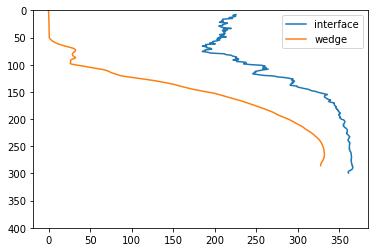

In [291]:
%pylab inline
fig, ax = plt.subplots()

ax.plot(faultVelMag, 
        (1. - markerEvalFault.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'interface'  )
ax.plot(mantleVelMag, 
        (1. - markerEvalMantle.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'wedge' )


ax.plot()

ax.set_ylim(400, 0)
#ax.set_xlim(0, 50)
ax.legend()


Populating the interactive namespace from numpy and matplotlib


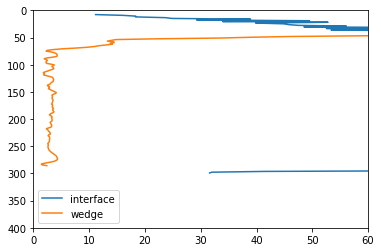

In [160]:
%pylab inline
fig, ax = plt.subplots()

ax.plot((2.*faultViscData*faultSr2InvData)*sf.stress/1e6, 
        (1. - markerEvalFault.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'interface'  )
ax.plot((2.*mantleViscData*mantleSr2InvData)*sf.stress/1e6, 
        (1. - markerEvalMantle.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'wedge' )


ax.plot()

ax.set_ylim(400, 0)
ax.set_xlim(0, 60)
ax.legend()


fig, ax = plt.subplots()

ax.plot(temperatureField.evaluate(markerEvalFault)[:,0],
         (1. - markerEvalFault.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'interface' )

ax.plot(temperatureField.evaluate(markerEvalMantle)[:,0],
         (1. - markerEvalMantle.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'wedge' )

ax.plot()

ax.set_ylim(400, 0)
#ax.set_xlim(0, 200)
ax.legend()

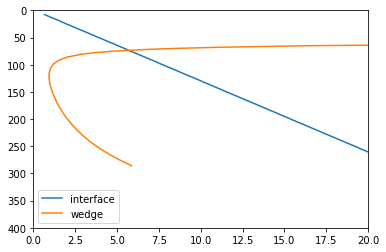

In [161]:
fig, ax = plt.subplots()

ax.plot(faultViscData,
         (1. - markerEvalFault.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'interface' )

ax.plot(mantleViscData,
         (1. - markerEvalMantle.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'wedge' )

ax.plot()

ax.set_ylim(400, 0)
ax.set_xlim(0, 20)
#ax.set_xscale('log')
ax.legend()

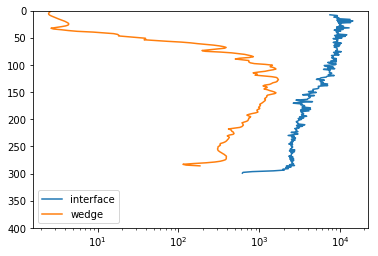

In [162]:
fig, ax = plt.subplots()

ax.plot(faultSr2InvData,
         (1. - markerEvalFault.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'interface' )

ax.plot(mantleSr2InvData,
         (1. - markerEvalMantle.particleCoordinates.data[:,1])*sf.lengthScale/1e3, label = 'wedge' )

ax.plot()

ax.set_ylim(400, 0)
#ax.set_xlim(0, 200)
ax.set_xscale('log')
ax.legend()